# Implementation of Mixture of Experts using Switch Transformers

## Instructions
Environment: Install pytorch >= 1.7.0 and torchvision >= 0.8.0 to avoid any issues caused by package versions.

## Mixture of Experts (MoE)

Mixture of Experts (MoE) is a machine learning technique that combines the predictions of multiple specialized models, known as experts, to solve a complex problem. The idea behind MoE is to divide a task into subtasks and assign each subtask to an expert model that specializes in that particular area. The final prediction is then made by combining the predictions of all the experts based on their expertise.

You can also refer to the article for in detailed explanation.

Sources:
1. Outrageously Large Neural Networks: The Sparsely-Gated Mixture-of-Experts Layer: [paper](https://arxiv.org/pdf/1701.06538.pdf)

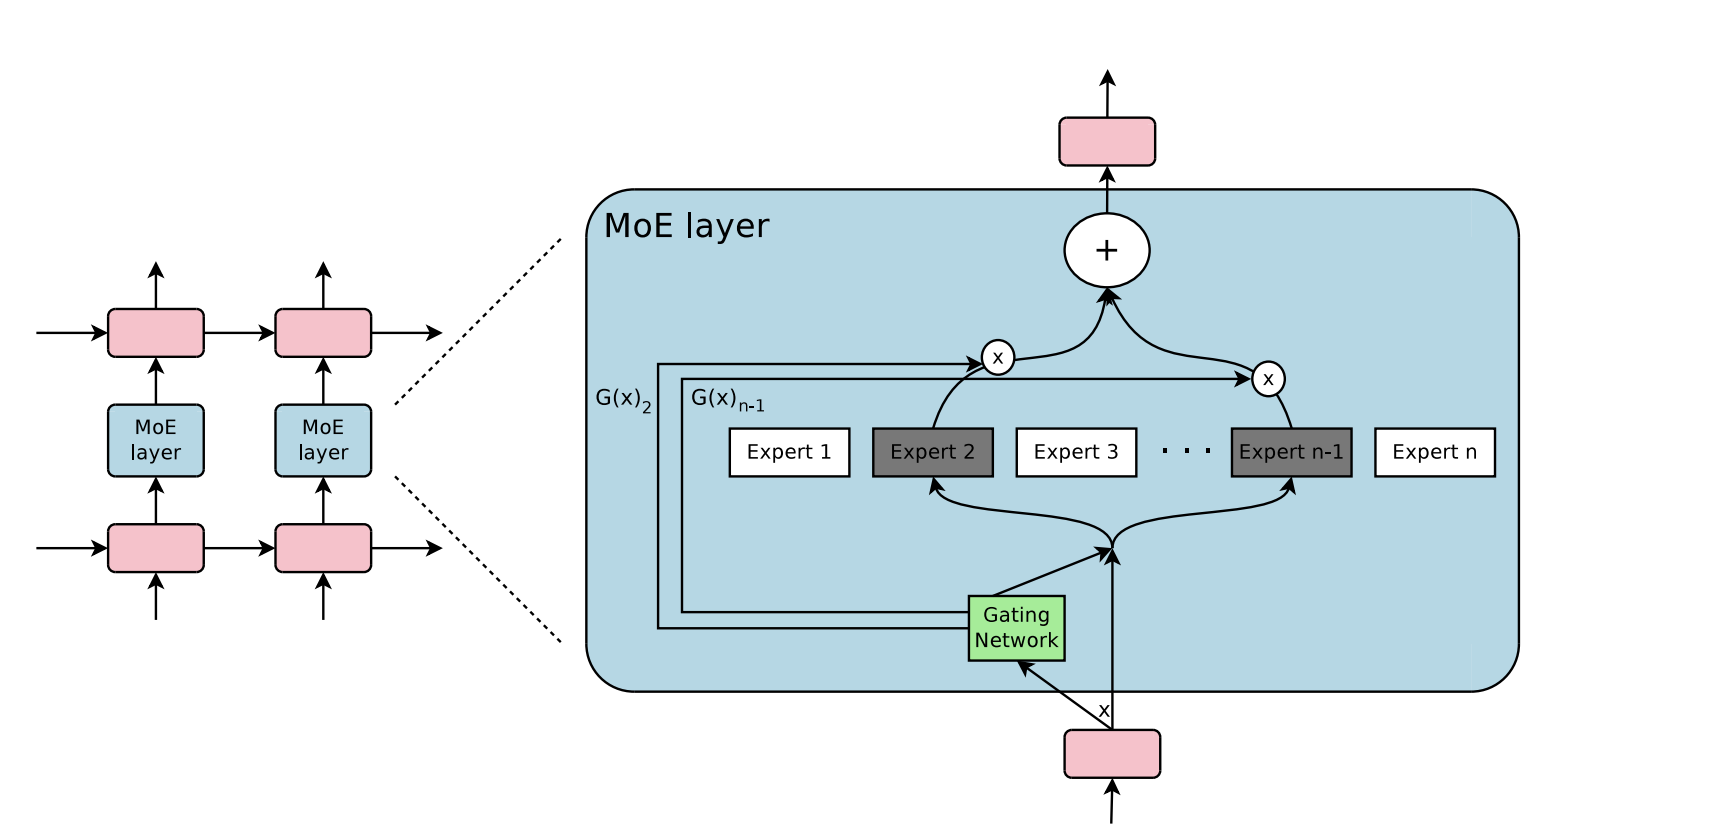


## Switch Transformers

The Switch Transformer is a variant of the standard Transformer architecture that introduces a modification to the feedforward network (FFN) layer. In the Switch Transformer, the FFN layer is replaced with a Mixture of Experts (MoE) routing layer. This layer consists of multiple expert networks that operate independently on the tokens in the input sequence.

You can also refer to the article for in detailed explanation.

Sources:

1. Switch Transformers: Scaling to trillion parameter models with simple and efficient sparsity [Paper](https://arxiv.org/abs/2101.03961)


In [ ]:
!pip install torchtext==0.16.0

In [ ]:
!pip install portalocker

## Hyperparameters

In [ ]:
embed_dim = 64  # Embedding size for each token.
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feedforward network.
num_experts = 8  # Number of experts used in the Switch Transformer.
batch_size = 50  # Batch size.
learning_rate = 0.0005  # Learning rate.
dropout_rate = 0.4  # Dropout rate.
num_epochs = 20  # Number of epochs
vocab_size = 20000  # Only consider the top 20k words
num_tokens_per_example = 200  # Only consider the first 200 words of each movie review\
num_tokens_per_batch = (
    batch_size * num_tokens_per_example
)  # Total number of tokens per batch.


## Download and prepare dataset

Step 1: Importing Libraries
We start by importing the necessary libraries for our project. These include PyTorch, Torchtext, and DataLoader. PyTorch is a popular library for machine learning, while Torchtext is used for handling text data. DataLoader helps manage batches of data during training.

Step 2: Loading Data
We load the IMDB dataset, which is commonly used for sentiment analysis tasks. This dataset contains movie reviews labeled as positive or negative. The data is split into training and testing sets.

Step 3: Tokenizing Text
We use a tokenizer to break down the text into individual words or tokens. The tokenizer is set to use the 'basic_english' configuration. A function named yield_tokens is defined to apply this tokenizer to the text data.

Step 4: Building Vocabulary
We build a vocabulary from the training data. This vocabulary includes a list of unique words from the dataset, limited to a certain number (vocab_size). Special tokens like <pad> for padding and <unk> for unknown words are also included.

Step 5: Preprocessing Text
We define two preprocessing functions: text_pipeline and label_pipeline. The text_pipeline function tokenizes the text and converts each word into a numerical index based on the vocabulary. The label_pipeline function adjusts the labels to be 0 or 1 instead of 1 or 2.

Step 6: Creating Batches
We create a function named collate_batch to process batches of data. This function pads the text to a uniform length (num_tokens_per_example), converts labels and text into tensors, and ensures that all text samples in a batch are the same length by padding with <pad> tokens.

Step 7: Setting Up Data Loaders
We set up data loaders for both the training and testing datasets. These data loaders manage the data in batches during training and testing, with a specified batch size (batch_size).

In [ ]:
import torch
import torchtext
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
import torch.nn.functional as F

train_iter, test_iter = torchtext.datasets.IMDB(root='./data', split=('train', 'test'))

tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for _, text in data_iter:
        # print(text)
        yield tokenizer(text)

vocab = torchtext.vocab.build_vocab_from_iterator(yield_tokens(train_iter), max_tokens=vocab_size, specials=["<pad>", "<unk>"])

vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: x-1

def collate_batch(batch):
    max_length = num_tokens_per_example
    pad = text_pipeline('<pad>')
    label_list, text_list = [], []
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = text_pipeline(_text)[:max_length]
         text_list.append((processed_text+pad*max_length)[:max_length])
    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = torch.tensor(text_list, dtype=torch.int64)
    return label_list.to(device), text_list.to(device)

train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)


The below code defines a module named TokenAndPositionEmbedding. It's designed to combine two types of embeddings:

Token Embeddings: These represent the meaning of words in a sentence.

Position Embeddings: These capture the position of each word in a sentence.

This module is often used in transformer-based models to provide both semantic and positional information about the input sequence. The combined embedding helps the model understand not only what words are present but also their order and context within the sentence.

In [ ]:
import torch.nn as nn

class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        self.pos_emb = nn.Embedding(num_embeddings=maxlen, embedding_dim=embed_dim)

    def forward(self, x):
        maxlen = x.size(-1)
        positions = torch.arange(start=0, end=maxlen, step=1, device=x.device)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
def create_feedforward_network(ff_dim, embed_dim):
    return nn.Sequential(
        nn.Linear(embed_dim, ff_dim),
        nn.ReLU(),
        nn.Linear(ff_dim, embed_dim)
    )

## Load Balance Loss for Switch Transformers

You can find the Pseudocode of this function from [Switch Transformers](https://arxiv.org/pdf/2101.03961.pdf). paper (page 33).

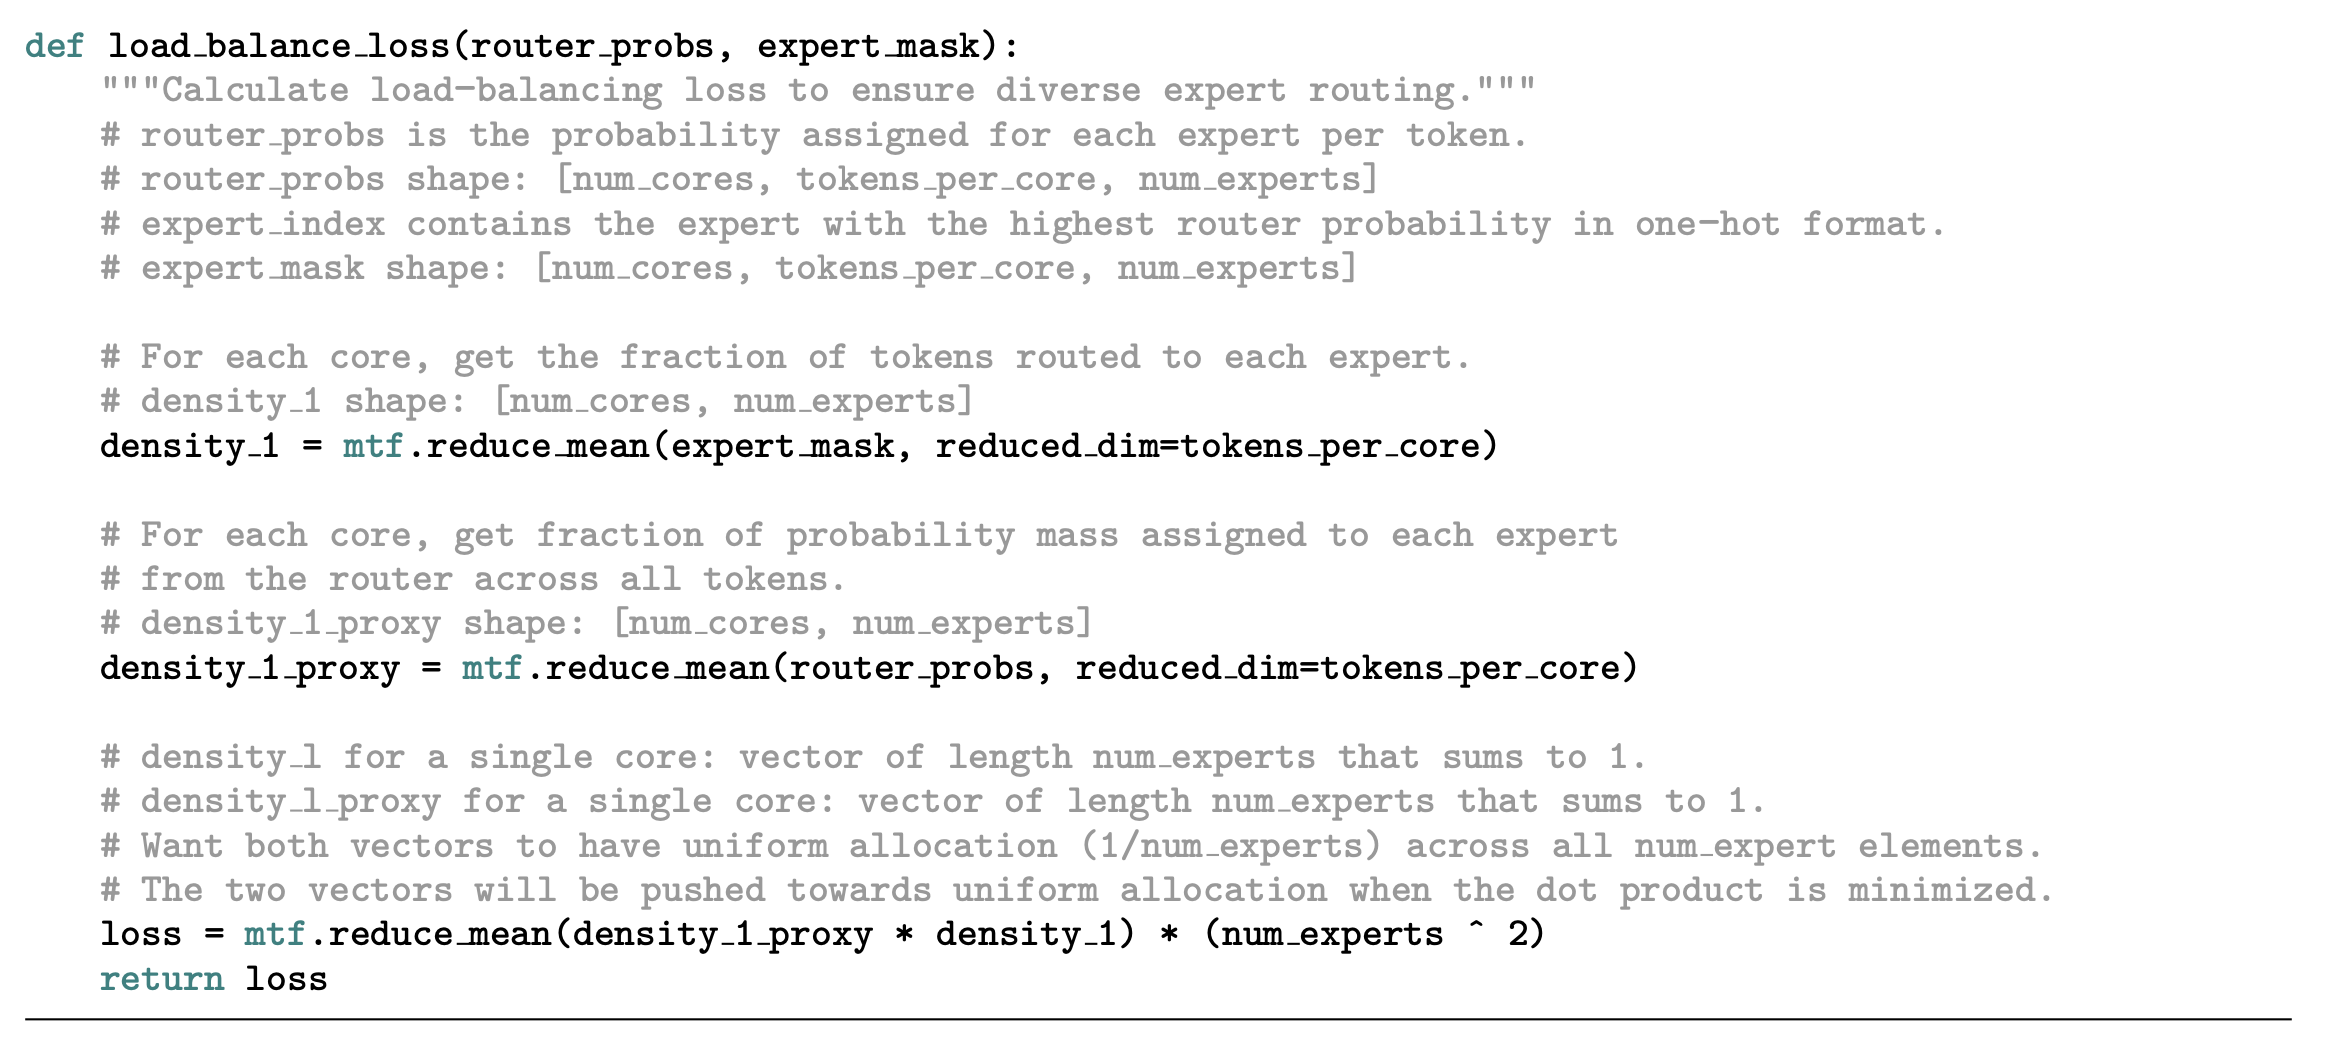

In [1]:
def load_balanced_loss(router_probs, expert_mask):
    # Compute the fraction of tokens routed to each expert (density_1).
    # Shape: [num_cores, num_experts]
    density_1 = torch.mean(expert_mask.float(), dim=1)

    # Compute the fraction of probability mass assigned to each expert (density_1_proxy).
    # Shape: [num_cores, num_experts]
    density_1_proxy = torch.mean(router_probs, dim=1)

    # Compute the dot product between density_1 and density_1_proxy for each core.
    # This encourages uniform allocation across experts.
    loss = torch.mean(density_1 * density_1_proxy) * (router_probs.shape[-1] ** 2)
    return loss

## Router for Switch Transformers

You can find the Pseudocode of this function from [Switch Transformers](https://arxiv.org/pdf/2101.03961.pdf). paper (page 34).



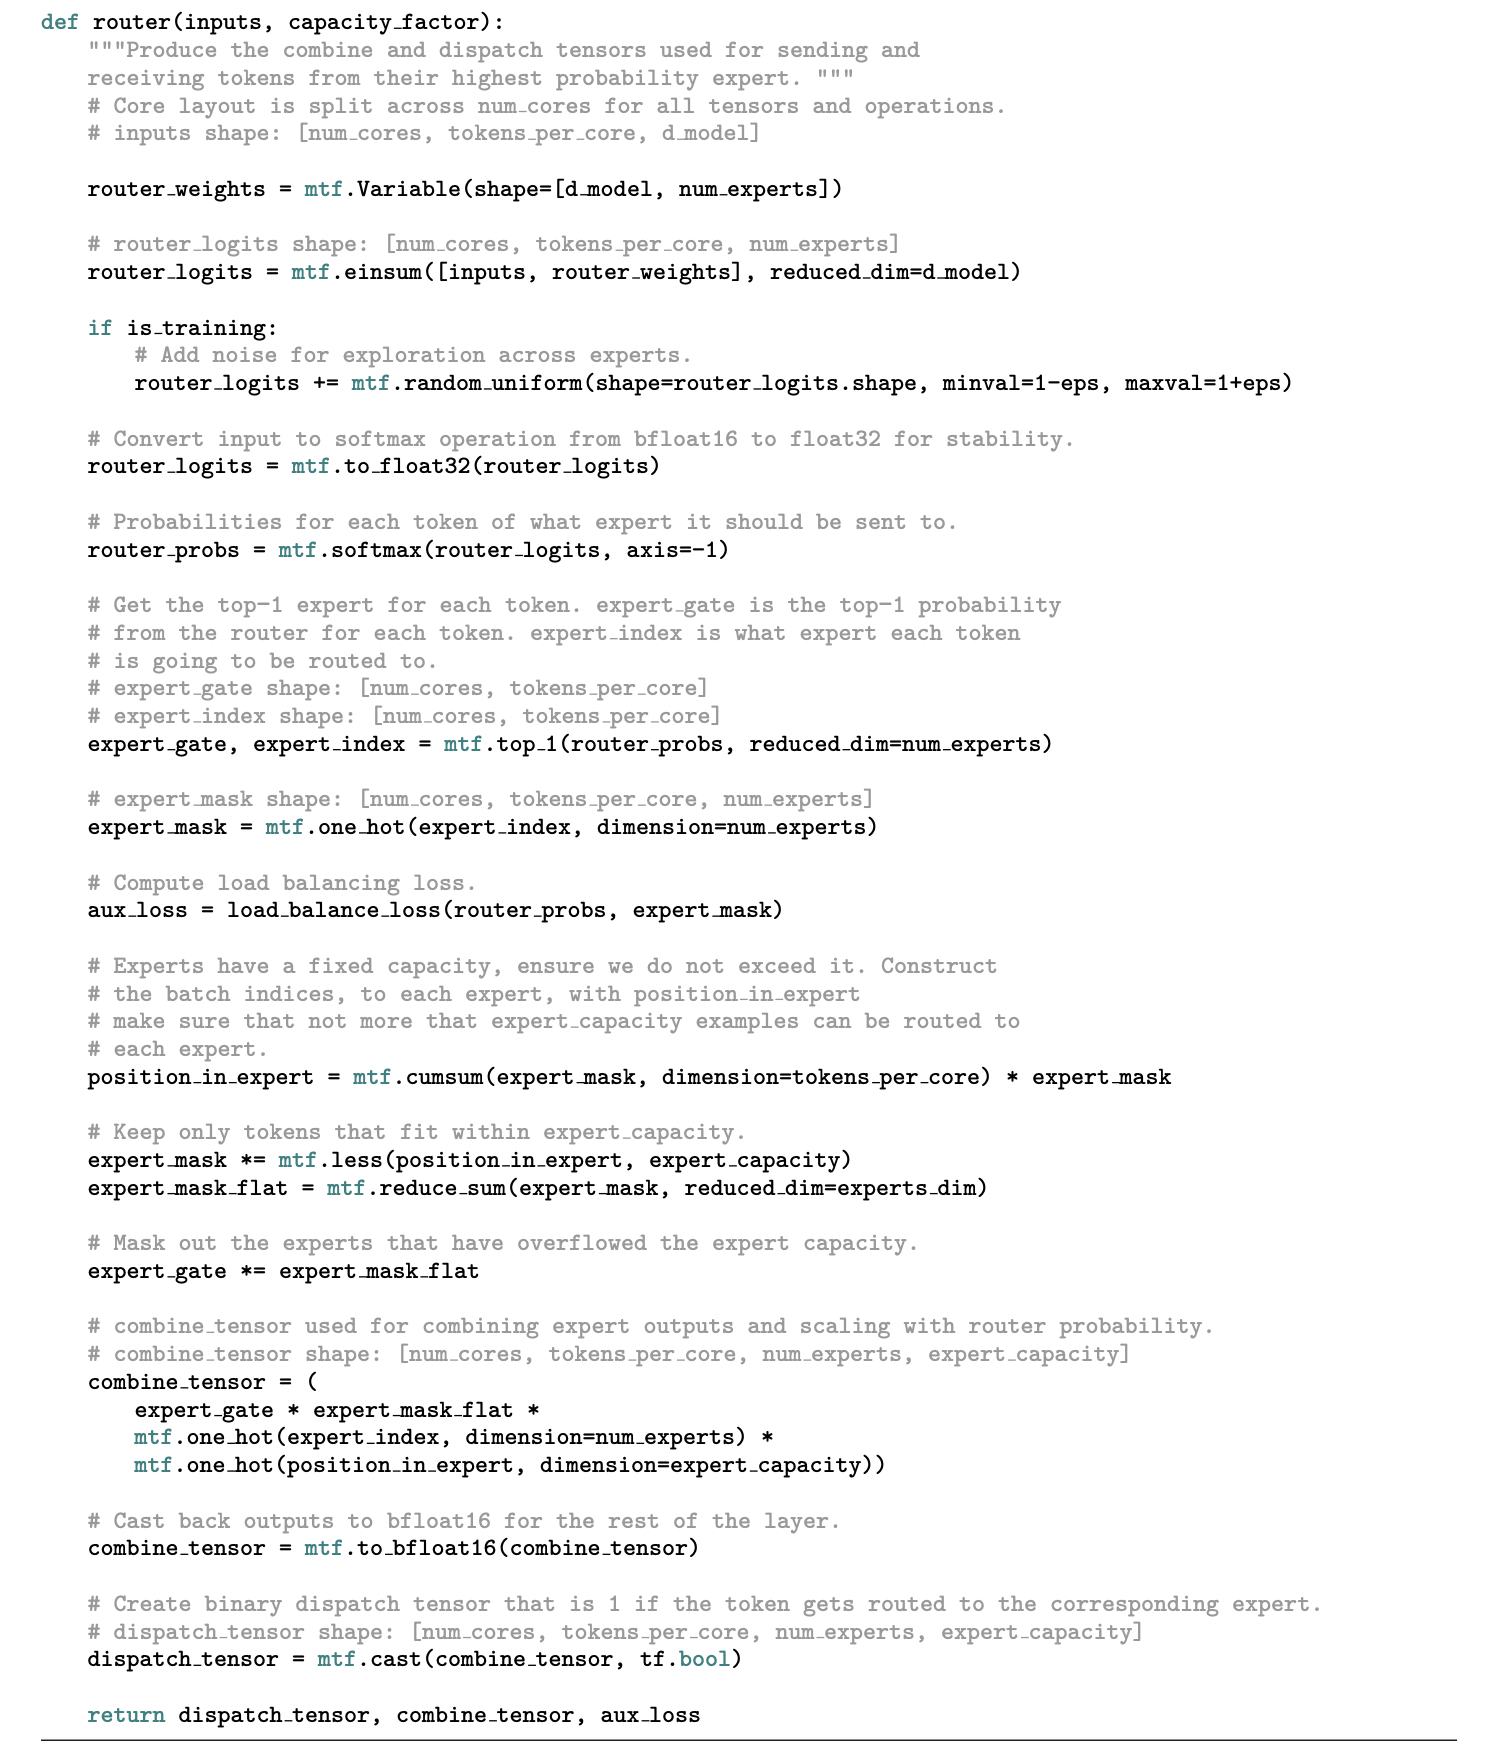

In [ ]:
class Router(nn.Module):
    def __init__(self, num_experts, expert_capacity):
        super().__init__()
        self.num_experts = num_experts
        self.route = nn.Linear(in_features=embed_dim, out_features=num_experts)
        self.expert_capacity = expert_capacity
        self.aux_loss = 0

    def forward(self, inputs, training=False):

        # Step 1: Compute router logits and probabilities
        router_logits = self.route(inputs)  # Shape: [tokens_per_batch, num_experts]
        router_probs = F.softmax(router_logits, dim=-1)  # Shape: [tokens_per_batch, num_experts]

        # Step 2: Expert selection - top-1 routing
        expert_weights, expert_indices = torch.topk(router_probs, k=1, dim=-1)  # Shape: [tokens_per_batch, 1]
        expert_mask = F.one_hot(expert_indices.squeeze(-1), self.num_experts).float()  # Shape: [tokens_per_batch, num_experts]

        # Step 3: Compute position in expert capacity
        position_in_expert = torch.cumsum(expert_mask, dim=0) * expert_mask - 1

        # Clamp indices to ensure they are within valid range
        position_in_expert = torch.clamp(position_in_expert, min=0, max=self.expert_capacity - 1)

        # Step 4: Create combine tensor with correct dimensions
        combine_tensor = torch.zeros(
            inputs.size(0),  # tokens_per_batch
            self.num_experts,
            self.expert_capacity,
            device=inputs.device
        )

        combine_tensor.scatter_(
            dim=2,
            index=position_in_expert.unsqueeze(-1).long(),
            src=(router_probs.unsqueeze(-1) * expert_mask.unsqueeze(-1))
        )

        # Step 5: Create dispatch tensor (binary mask)
        dispatch_tensor = (combine_tensor > 0).float()

        # Step 6: Calculate load balancing loss
        density_1 = expert_mask.mean(dim=0)  # Fraction of tokens assigned to each expert
        density_1_proxy = router_probs.mean(dim=0)  # Fraction of probability mass assigned by router
        aux_loss = (density_1_proxy * density_1).sum() * (self.num_experts ** 2)

        # print("router_probs shape:", router_probs.shape)
        # print("combine_tensor shape", combine_tensor.shape)
        # print("dispatch_tensor shape:", dispatch_tensor.shape)

        return dispatch_tensor, combine_tensor, aux_loss

##  Switch Transformer layer

You can find the Pseudocode of this function from [Switch Transformers](https://arxiv.org/pdf/2101.03961.pdf). paper (page 35).

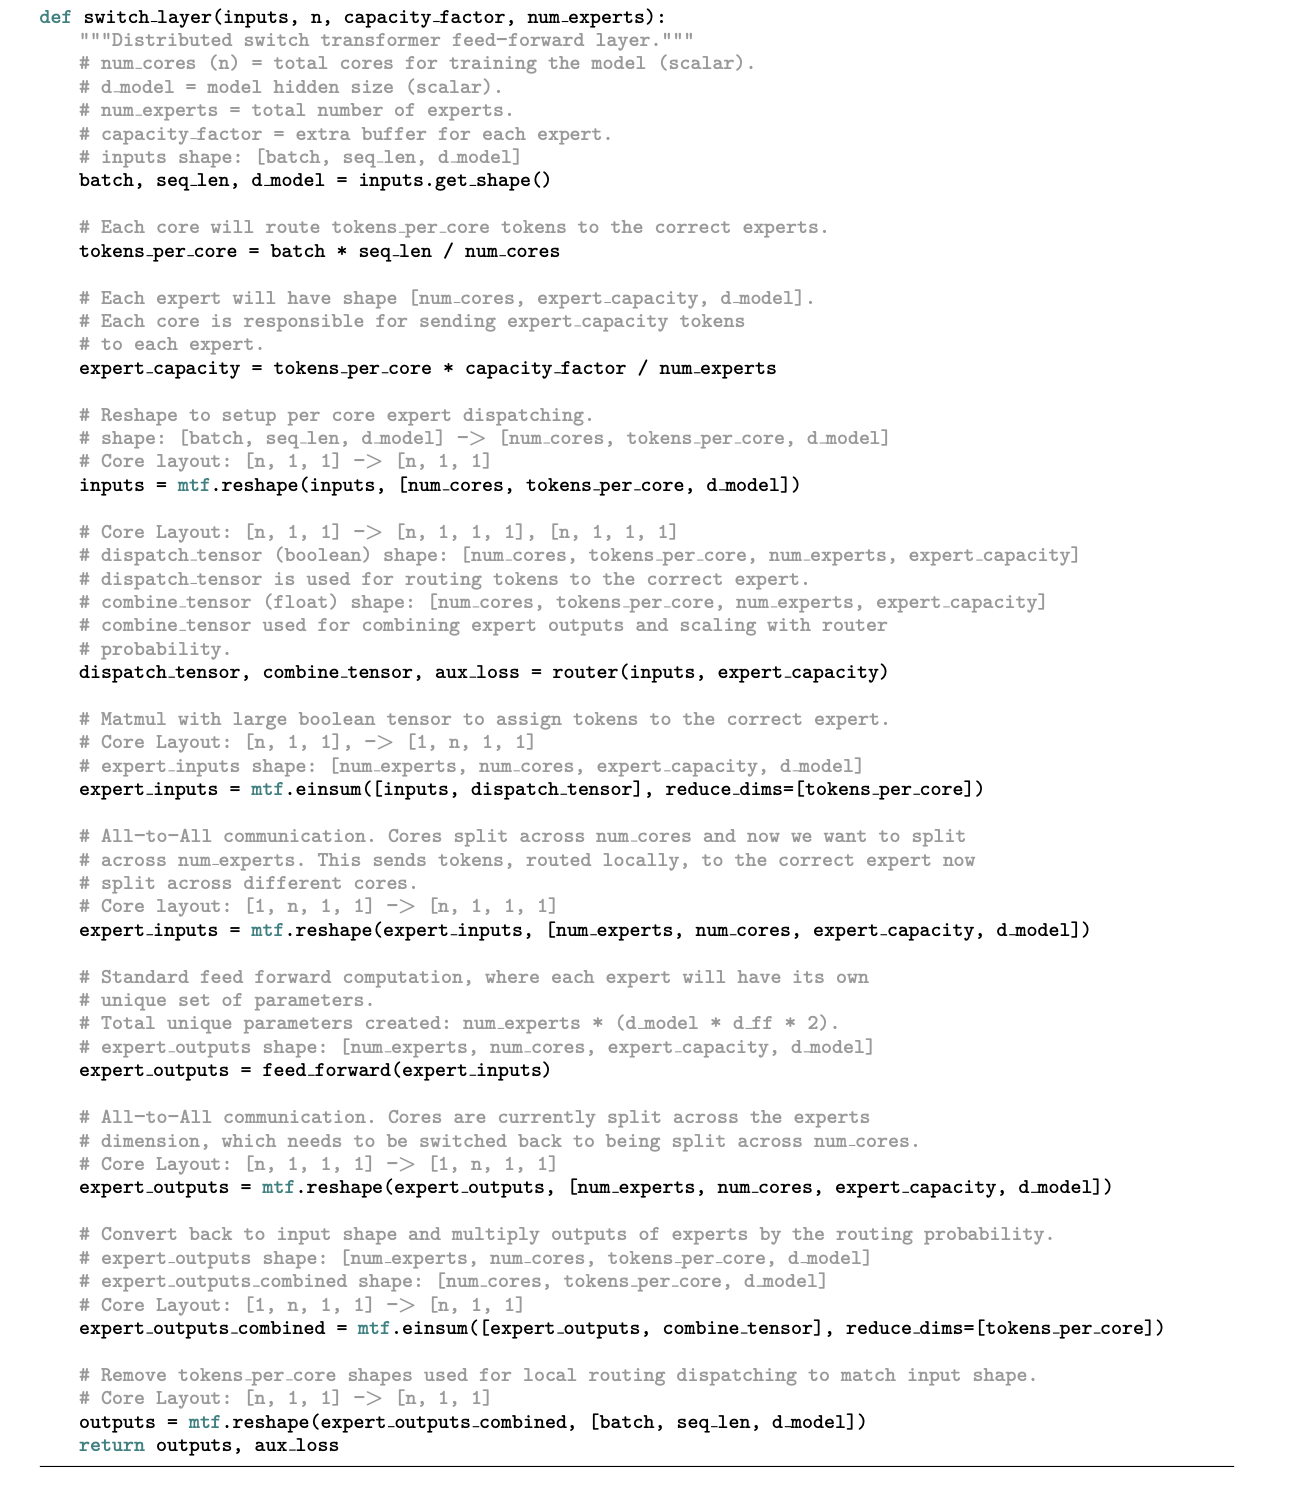

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Switch(nn.Module):
    def __init__(self, num_experts, embed_dim, ff_dim, num_tokens_per_batch, capacity_factor=1):
        super().__init__()
        self.num_experts = num_experts
        self.embed_dim = embed_dim
        self.experts = nn.ModuleList([
            create_feedforward_network(ff_dim, embed_dim) for _ in range(num_experts)
        ])
        self.expert_capacity = int(num_tokens_per_batch // self.num_experts * capacity_factor)

        self.router = Router(self.num_experts, self.expert_capacity)

    def forward(self, inputs):
        """
        Forward pass of Switch Transformer based on pseudocode.
        Args:
            inputs (torch.Tensor): Input tensor of shape [tokens_per_batch, embed_dim] or [batch_size, tokens_per_example, embed_dim].
        Returns:
            outputs (torch.Tensor): Aggregated outputs from all experts.
            aux_loss (torch.Tensor): Load balancing loss.
        """
        # Step 1: Flatten inputs if they are multi-dimensional.
        if inputs.ndim == 3:
            batch_size, tokens_per_example, embed_dim = inputs.size()
            assert embed_dim == self.embed_dim, "Input embedding dimension must match."
            inputs_flat = inputs.view(-1, embed_dim)  # Flatten input to [tokens_per_batch, embed_dim]
        else:
            inputs_flat = inputs

        # Step 2: Route tokens to experts using the router.
        dispatch_tensor, combine_tensor, aux_loss = self.router(inputs_flat)

        # Step 3: Initialize output tensor for aggregation.
        outputs_flat = torch.zeros_like(inputs_flat)

        # Step 4: Process tokens through respective experts.
        for i, expert in enumerate(self.experts):
            # Select tokens routed to this expert using dispatch_tensor.
            expert_inputs = torch.matmul(dispatch_tensor[:, i].transpose(0, 1), inputs_flat)  # Shape: [expert_capacity, embed_dim]

            # Pass selected tokens through the feedforward network.
            expert_outputs = expert(expert_inputs)  # Shape: [expert_capacity, embed_dim]

            # Aggregate results using combine_tensor.
            outputs_flat += torch.matmul(combine_tensor[:, i], expert_outputs)

        # Step 5: Reshape back to original shape if necessary.
        if inputs.ndim == 3:
            outputs = outputs_flat.view(batch_size, tokens_per_example, embed_dim)
        else:
            outputs = outputs_flat

        return outputs, aux_loss


Steps: (TransformerBlock)

Self-Attention:

* The input is passed through a multi-head attention layer (self.att).

* The output is then passed through a dropout layer (self.dropout1) to prevent overfitting.

* The result is added to the original input and passed through a layer normalization layer (self.layernorm1) to stabilize the learning process.

Feed-Forward Network (FFN):

* The output from the self-attention block is passed through the FFN (self.ffn).

* If the FFN returns a tuple (e.g., output and auxiliary loss), it is unpacked; otherwise, the auxiliary loss is set to 0.

* The FFN output is then passed through another dropout layer (self.dropout2) for regularization.

Final Output:

* The FFN output is added to the output from the self-attention block (x) and passed through another layer normalization layer (self.layernorm2).

* The final output and any auxiliary loss are returned.

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ffn, dropout_rate=0.1):
        super().__init__()

        self.att = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        # The ffn can be either a standard feedforward network or a switch
        # layer with a Mixture of Experts.
        self.ffn = ffn
        self.layernorm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, inputs, training=False):

        # Self-attention block with residual connection and layer normalization.
        attn_output, _ = self.att(inputs, inputs, inputs)
        attn_output = self.dropout1(attn_output)
        x = self.layernorm1(inputs + attn_output)

        # Feed-forward network or Switch layer with potential auxiliary loss.
        ffn_output = self.ffn(x)
        if isinstance(ffn_output, tuple):
            ffn_output, aux_loss = ffn_output
        else:
            aux_loss = 0

        ffn_output = self.dropout2(ffn_output)
        final_output = self.layernorm2(x + ffn_output)

        return final_output, aux_loss


Model:

* Embedding:The input is passed through the embedding layer (self.embedding_layer) to convert tokens into vectors.

* Transformer Block: The embedded input is then processed by the transformer block (self.transformer_block), which includes the Switch layer. The output from this block is a tuple containing the processed input and any auxiliary loss.

* Pooling: The output from the transformer block is pooled along the sequence dimension (x.mean(dim=1)), effectively reducing it to a single vector per example.

* Classification Head: The pooled output is passed through a dropout layer (self.dropout1) for regularization. It is then passed through a fully connected layer (self.fc1) followed by a ReLU activation function (self.relu).Another dropout layer (self.dropout2) is applied. Finally, the output is passed through a final fully connected layer (self.fc2) and a softmax activation function (self.softmax) to produce classification probabilities.

The model is designed for text classification tasks, such as sentiment analysis. It leverages the transformer architecture with a Switch layer to efficiently process sequential data. The use of a Mixture of Experts in the Switch layer allows for more efficient computation by activating only a subset of experts for each input token.

In [ ]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, num_experts, embed_dim, ff_dim, num_tokens_per_batch, num_tokens_per_example, vocab_size, dropout_rate):
        super().__init__()

        self.embedding_layer = TokenAndPositionEmbedding(num_tokens_per_example, vocab_size, embed_dim)
        self.switch = Switch(num_experts, embed_dim, ff_dim, num_tokens_per_batch)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, self.switch)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(embed_dim, ff_dim)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(ff_dim, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, inputs):

        x = self.embedding_layer(inputs)
        x, aux_loss = self.transformer_block(x)
        x = x.mean(dim=1)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        outputs = self.fc2(x)
        outputs = self.softmax(outputs)
        return outputs, aux_loss

## Training the model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import json

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for batch_idx, (labels, inputs) in enumerate(dataloader):

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs, aux_loss = model(inputs)
        loss = criterion(outputs, labels) + aux_loss

        print("loss: ", (loss - aux_loss).item(), "aux_loss: ", aux_loss.item())

        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for batch_idx, (labels, inputs) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, aux_loss = model(inputs)
            loss = criterion(outputs, labels) + aux_loss

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    return epoch_loss, epoch_acc

def run_experiment(model, train_dataloader, val_dataloader, learning_rate, num_epochs, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_dataloader, criterion, optimizer, device)
        test_loss, test_acc = evaluate(model, val_dataloader, criterion, device)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
        print("--" * 20)

        log_filename = "training_logs.json"
        # Load existing logs if the file exists, else start with an empty list.
        if os.path.exists(log_filename):
            with open(log_filename, "r") as f:
                logs = json.load(f)
        else:
            logs = []

        # Append current epoch log.
        logs.append({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": float(train_acc),
            "test_loss": test_loss,
            "test_acc": float(test_acc)
        })

        # Save logs back to the JSON file.
        with open(log_filename, "w") as f:
            json.dump(logs, f, indent=4)

train_dataloader = train_loader
val_dataloader = test_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model = Model(num_experts, embed_dim, ff_dim, num_tokens_per_batch, num_tokens_per_example, vocab_size, dropout_rate)

model.to(device)

run_experiment(model, train_dataloader, val_dataloader, learning_rate, num_epochs, device)



Streaming output truncated to the last 5000 lines.
loss:  0.40581846237182617 aux_loss:  7.998330593109131
loss:  0.41527843475341797 aux_loss:  8.000564575195312
loss:  0.36065101623535156 aux_loss:  8.001163482666016
loss:  0.4259824752807617 aux_loss:  7.995556831359863
loss:  0.42436695098876953 aux_loss:  7.994784355163574
loss:  0.43463993072509766 aux_loss:  7.997617721557617
loss:  0.4097270965576172 aux_loss:  7.999855041503906
loss:  0.5408620834350586 aux_loss:  8.00101089477539
loss:  0.4139060974121094 aux_loss:  8.000438690185547
loss:  0.4080924987792969 aux_loss:  8.001646041870117
loss:  0.3500795364379883 aux_loss:  8.002439498901367
loss:  0.3898429870605469 aux_loss:  8.00203800201416
loss:  0.39554691314697266 aux_loss:  8.002082824707031
loss:  0.4677400588989258 aux_loss:  8.001946449279785
loss:  0.43360137939453125 aux_loss:  8.002962112426758
loss:  0.44913578033447266 aux_loss:  8.00048828125
loss:  0.43780994415283203 aux_loss:  8.000110626220703
loss:  0.34